# Iris Classification with KNN (K-Nearest Neighbors)


## Student: **`OUEDRAOGO Taoufiq`**
---

The aim of the project is to test the KNN (K-Nearest Neighbors) algorithm on the Iris dataset to classify a flower according to its characteristics (petal length and width):
- Visualise the results to better understand the model's performance
- Understand the impact of different KNN parameters on the classification of Iris species

In [443]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve, auc

In [444]:
df = pd.read_csv('data/iris.csv')
print(df.shape)
df.head()

(150, 3)


,petal_length,petal_width,species
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0


# Exploratory Data Analysis

In [445]:
# Mapping numeric labels to species names
label = {0: "setosa", 1: "versicolor", 2: "virginica"}
# Assigning colors to each species
global colors
colors = {0: "g", 1: "r", 2: "b"}  

We confirm that :
- All columns contain no missing values
- The column data types are as expected: d
  - Numerical characteristics for `petal_length` and `petal_width`
  - Categorical characteristic for `species`

In [446]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   petal_length  150 non-null    float64
 1   petal_width   150 non-null    float64
 2   species       150 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 3.6 KB


In [447]:
df['species'].unique()

array([0, 1, 2])

The results show that :
- Petal length (petal_length) varies greatly, with a wide spread around the mean.
- Petal width (petal_width) shows less variation.
- The `species` variable shows little variation because it is categorical, representing distinct species (0, 1, 2).

In [448]:
pd.concat([df.describe().T, df.var().to_frame(name='variance')], axis=1)

,count,mean,std,min,25%,50%,75%,max,variance
petal_length,150.0,3.758667,1.764420,1.0,1.6,4.35,5.1,6.9,3.113179
petal_width,150.0,1.198667,0.763161,0.1,0.3,1.30,1.8,2.5,0.582414
species,150.0,1.000000,0.819232,0.0,0.0,1.00,2.0,2.0,0.671141


# Distribution of Variables

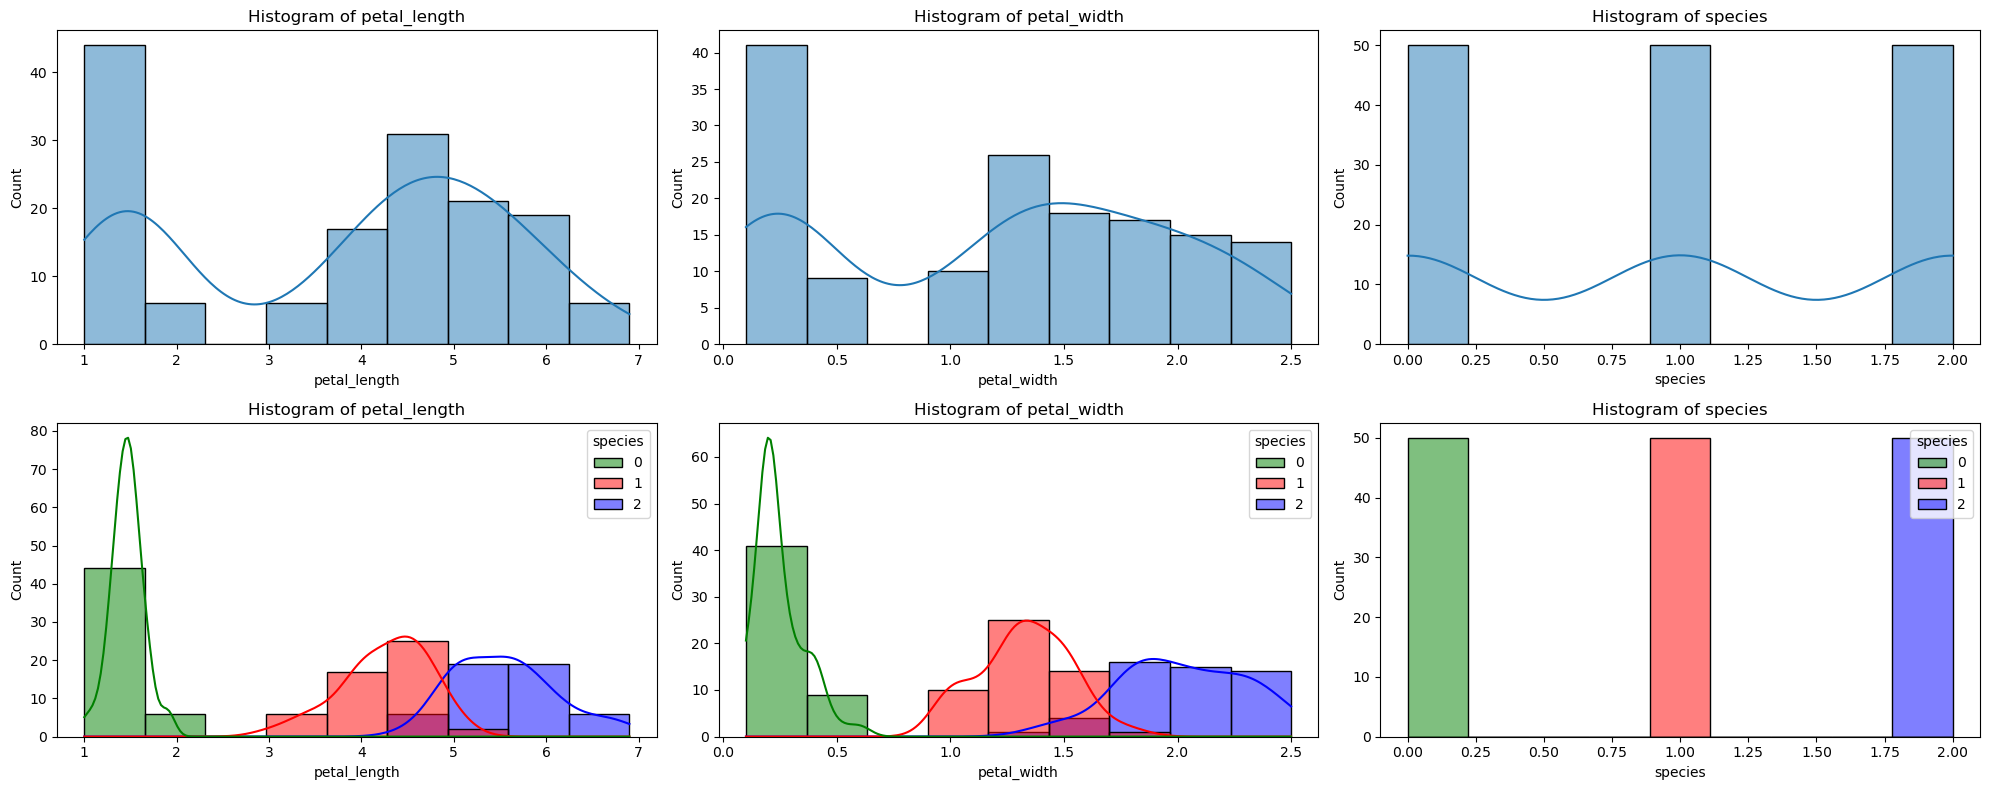

In [449]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8))

for i in range(3):
    sns.histplot(data=df, x=df.columns[i], ax=axes[0, i], kde=True)
    axes[0, i].set_title(f'Histogram of {df.columns[i]}')
    
for i in range(3):
    sns.histplot(data=df, x=df.columns[i], kde=True, hue='species', palette=colors, ax=axes[1, i])
    axes[1, i].set_title(f'Histogram of {df.columns[i]}')
    
plt.tight_layout()
plt.show()

# Correlation Matrix

## Entire Dataset Correlation Matrix

The correlation matrix shows a very strong relationship between petal length (petal_length) and petal width (petal_width), with a correlation coefficient of 0.96. 

This indicates that these 2 variables are highly correlated (strong linear relationship): as petal length increases, petal width tends to increase as well.

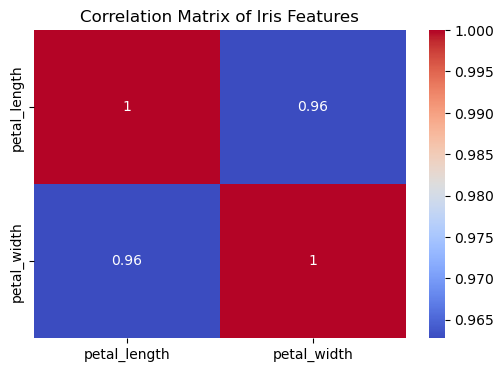

In [450]:
# Compute the correlation matrix
corr = df.drop(columns='species').corr()

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Iris Features')
plt.show()

## Correlation Matrix by `Specy`

The correlation matrices for the different flower species show variable relationships between petal length and petal width:

- Setosa (species 0): The correlation is low (0.31), which means that there is no marked linear relationship between petal length and petal width for this species. The two characteristics are relatively independent.

- Versicolor (species 1): The correlation is moderate (0.79), suggesting that petal length and petal width are more closely related for this species. An increase in petal length tends to be accompanied by an increase in petal width.

- Virginica (species 2): The correlation is weak (0.32), similar to that for the species setosa. This indicates that for virginica, there is no strong relationship between petal length and petal width.


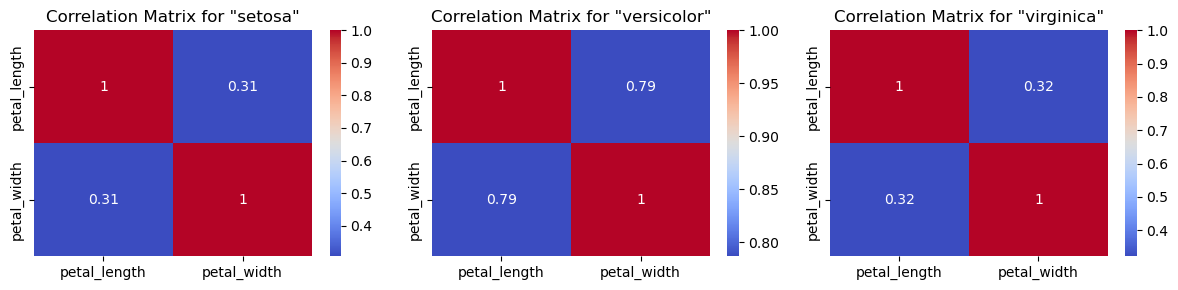

In [451]:
# For each species, compute the correlation matrix and plot
fig, axes = plt.subplots(1, len(df['species'].unique()), figsize=(12, 3))
species_list = df['species'].unique()
for i, species in enumerate(species_list):
    species_df = df[df['species'] == species].drop(columns='species')    
    corr = species_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[i])
    axes[i].set_title(f'Correlation Matrix for \"{label[species]}\"')
    
plt.tight_layout()
plt.show()

# Boxplots


The graph contains two sections of boxplots showing the distribution of petal lengths and widths.

These visualisations provide a better understanding of how the variables vary between species and highlight important differences, which is useful for classification models.


The first row of boxplots represents the general distribution of these measurements for all the data, without distinction of species. Each box shows the median, the quartiles (25th to 75th percentile) and the extreme values. This highlights the overall variability of petal lengths and widths, with significant dispersion.

The second row shows the separate distributions by species (setosa, versicolor and virginica). Setosa is clearly distinguished by lower values and less dispersion for petal length and width. On the other hand, the distributions of versicolor and virginica overlap to a greater extent, which may make them more difficult to distinguish.

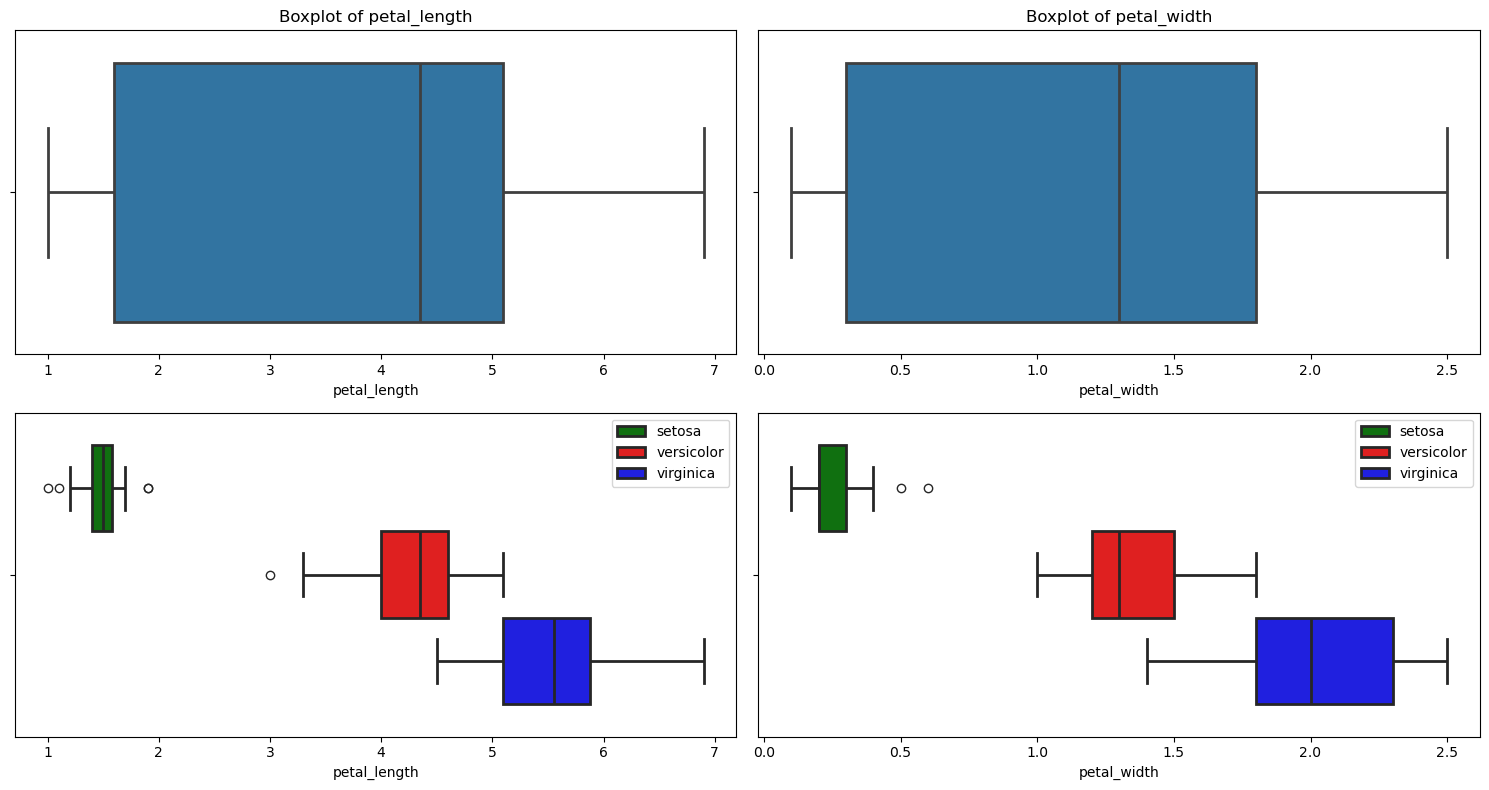

In [452]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Plotting each boxplot and adding a red line for the mean
for i in range(2):
    sns.boxplot(data=df, x=df.columns[i], ax=axes[0, i], linewidth=2)
    axes[0, i].set_title(f'Boxplot of {df.columns[i]}')

# Boxplots with hues for 'specy' column and mean lines
for i in range(2):
    sns.boxplot(data=df, x=df.columns[i], hue='species', ax=axes[1, i], palette=colors, linewidth=2)
    handles, _ = axes[1, i].get_legend_handles_labels()
    axes[1, i].legend(handles, label.values())

plt.tight_layout()
plt.show()

# Modeling

### Splitting data into features and target

In [453]:
X = df.drop(columns=['species'])
y = df['species']

### Create and train the KNN model

In [454]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k) 
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

`metric : minkowski`: The metric used to calculate distances between points. minkowski' is a generalisation of the Euclidean distance and the Manhattan distance, and its parameter p determines the exact form of the distance.

`p : 2`: This defines the distance used by the Minkowski metric. If p=2, the distance is the Euclidean distance (L2 norm)

In [455]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

## Tests

The KNN model is based on the dimensions of the petal (length and width) 

The `predict_` function trains a KNN model with the data, predicts the species for a given new point and also returns the nearest neighbours

The `plot` function visualises the results by displaying a graph with the existing data, the predicted point marked with a cross and the nearest neighbours in black

The `predict_and_plot` function combines the first two in a single step, making the prediction and generating the plot. This makes it easy to predict and visualise the species of a flower based on its dimensions.

In [456]:
# Splitting data into features and target
X = df.drop(columns=['species'])
y = df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dfi = pd.concat([X_train, y_train], axis=1)

In [457]:
def predict_(L, l, k, df=df):
    #dfi = pd.concat([X_train, y_train], axis=1)
    data = pd.DataFrame([[L, l]], columns=df.columns[:2]) 
    
    # Splitting data into features and target
    X_train = df.drop(columns=['species'])
    y_train = df['species']
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Create and Train KNN model
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(X_train, y_train)
    # Get the score (mean accuracy)
    score = f'{knn.score(X_train, y_train):.3f}'
    
    # Use Knn for predictions
    prediction = knn.predict(data)[0]
    print(f'Prediction for Longueur ({L} cm) and Largeur ({l} cm) and K={k}, Training mean_accuracy={score} --------->  \"{prediction}\" ({label[prediction]})')

    # Get the neighbors indices and their coordinates
    distances, indices = knn.kneighbors(data)
    # Get the neighbors data points
    #neighbors = df.iloc[indices[0]] 
    neighbors = dfi.iloc[indices[0]]
    return knn, score, prediction, neighbors


def plot(L, l, k, score, neighbors, prediction, ax, df=df):  
    global colors
    scatter = sns.scatterplot(data=df, x='petal_length', y='petal_width', hue='species', ax=ax, palette=colors)
    ax.scatter(L, l, color=colors[prediction], marker="X", s=150, label='New Point')
    # Plot the neighbors as small points
    ax.scatter(neighbors['petal_length'], neighbors['petal_width'], marker='o', color='black')#color=color_n)#, color='black', s=100, marker='s')

    handles, _ = scatter.get_legend_handles_labels() 
    ax.legend(handles=handles, labels=label.values()) 
    ax.set_title(f"KNN with k={k}, mean_accuracy={score}", fontweight='bold')


def predict_and_plot(L, l, k, ax=None, df=df):
    knn, score, prediction, neighbors = predict_(L, l, k, df=df)
    if ax:
        plot(L, l, k, score, neighbors, prediction, ax, df=df)
    return score

The prediction results for different k values show varied predictions for the flower species.


The results also show that the accuracy varies slightly as a function of the value of k, but the predicted species fluctuates mainly between ‘setosa’ and ‘versicolor’ depending on the value of k, indicating that the model finds closer neighbours to these two species for this particular combination of petal dimensions. This is all the more understandable when observing the results of the graphs (the new point added is between ‘versicolor’ and ‘setosa’).



**The nearest neighbours are coloured black in the graphs**. 


We notice that from k=5, the number of neighbours selected does not correspond to the value of k. For example, for k=5, only 4 neighbours are selected.

For k=5, we see that the predicted class is ‘versicolor’ whereas for k=4, the predicted class is ‘setosa’. We therefore have an anomaly because for the same number of neighbours selected, the predicted classes are different. 

Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=1, Training mean_accuracy=0.990 --------->  "1" (versicolor)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=2, Training mean_accuracy=0.971 --------->  "0" (setosa)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=3, Training mean_accuracy=0.971 --------->  "0" (setosa)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=4, Training mean_accuracy=0.962 --------->  "0" (setosa)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=5, Training mean_accuracy=0.943 --------->  "1" (versicolor)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=6, Training mean_accuracy=0.952 --------->  "0" (setosa)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=7, Training mean_accuracy=0.952 --------->  "0" (setosa)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=8, Training mean_accuracy=0.962 --------->  "0" (setosa)
Prediction for Longueur (2.5 cm) and Largeur (0.

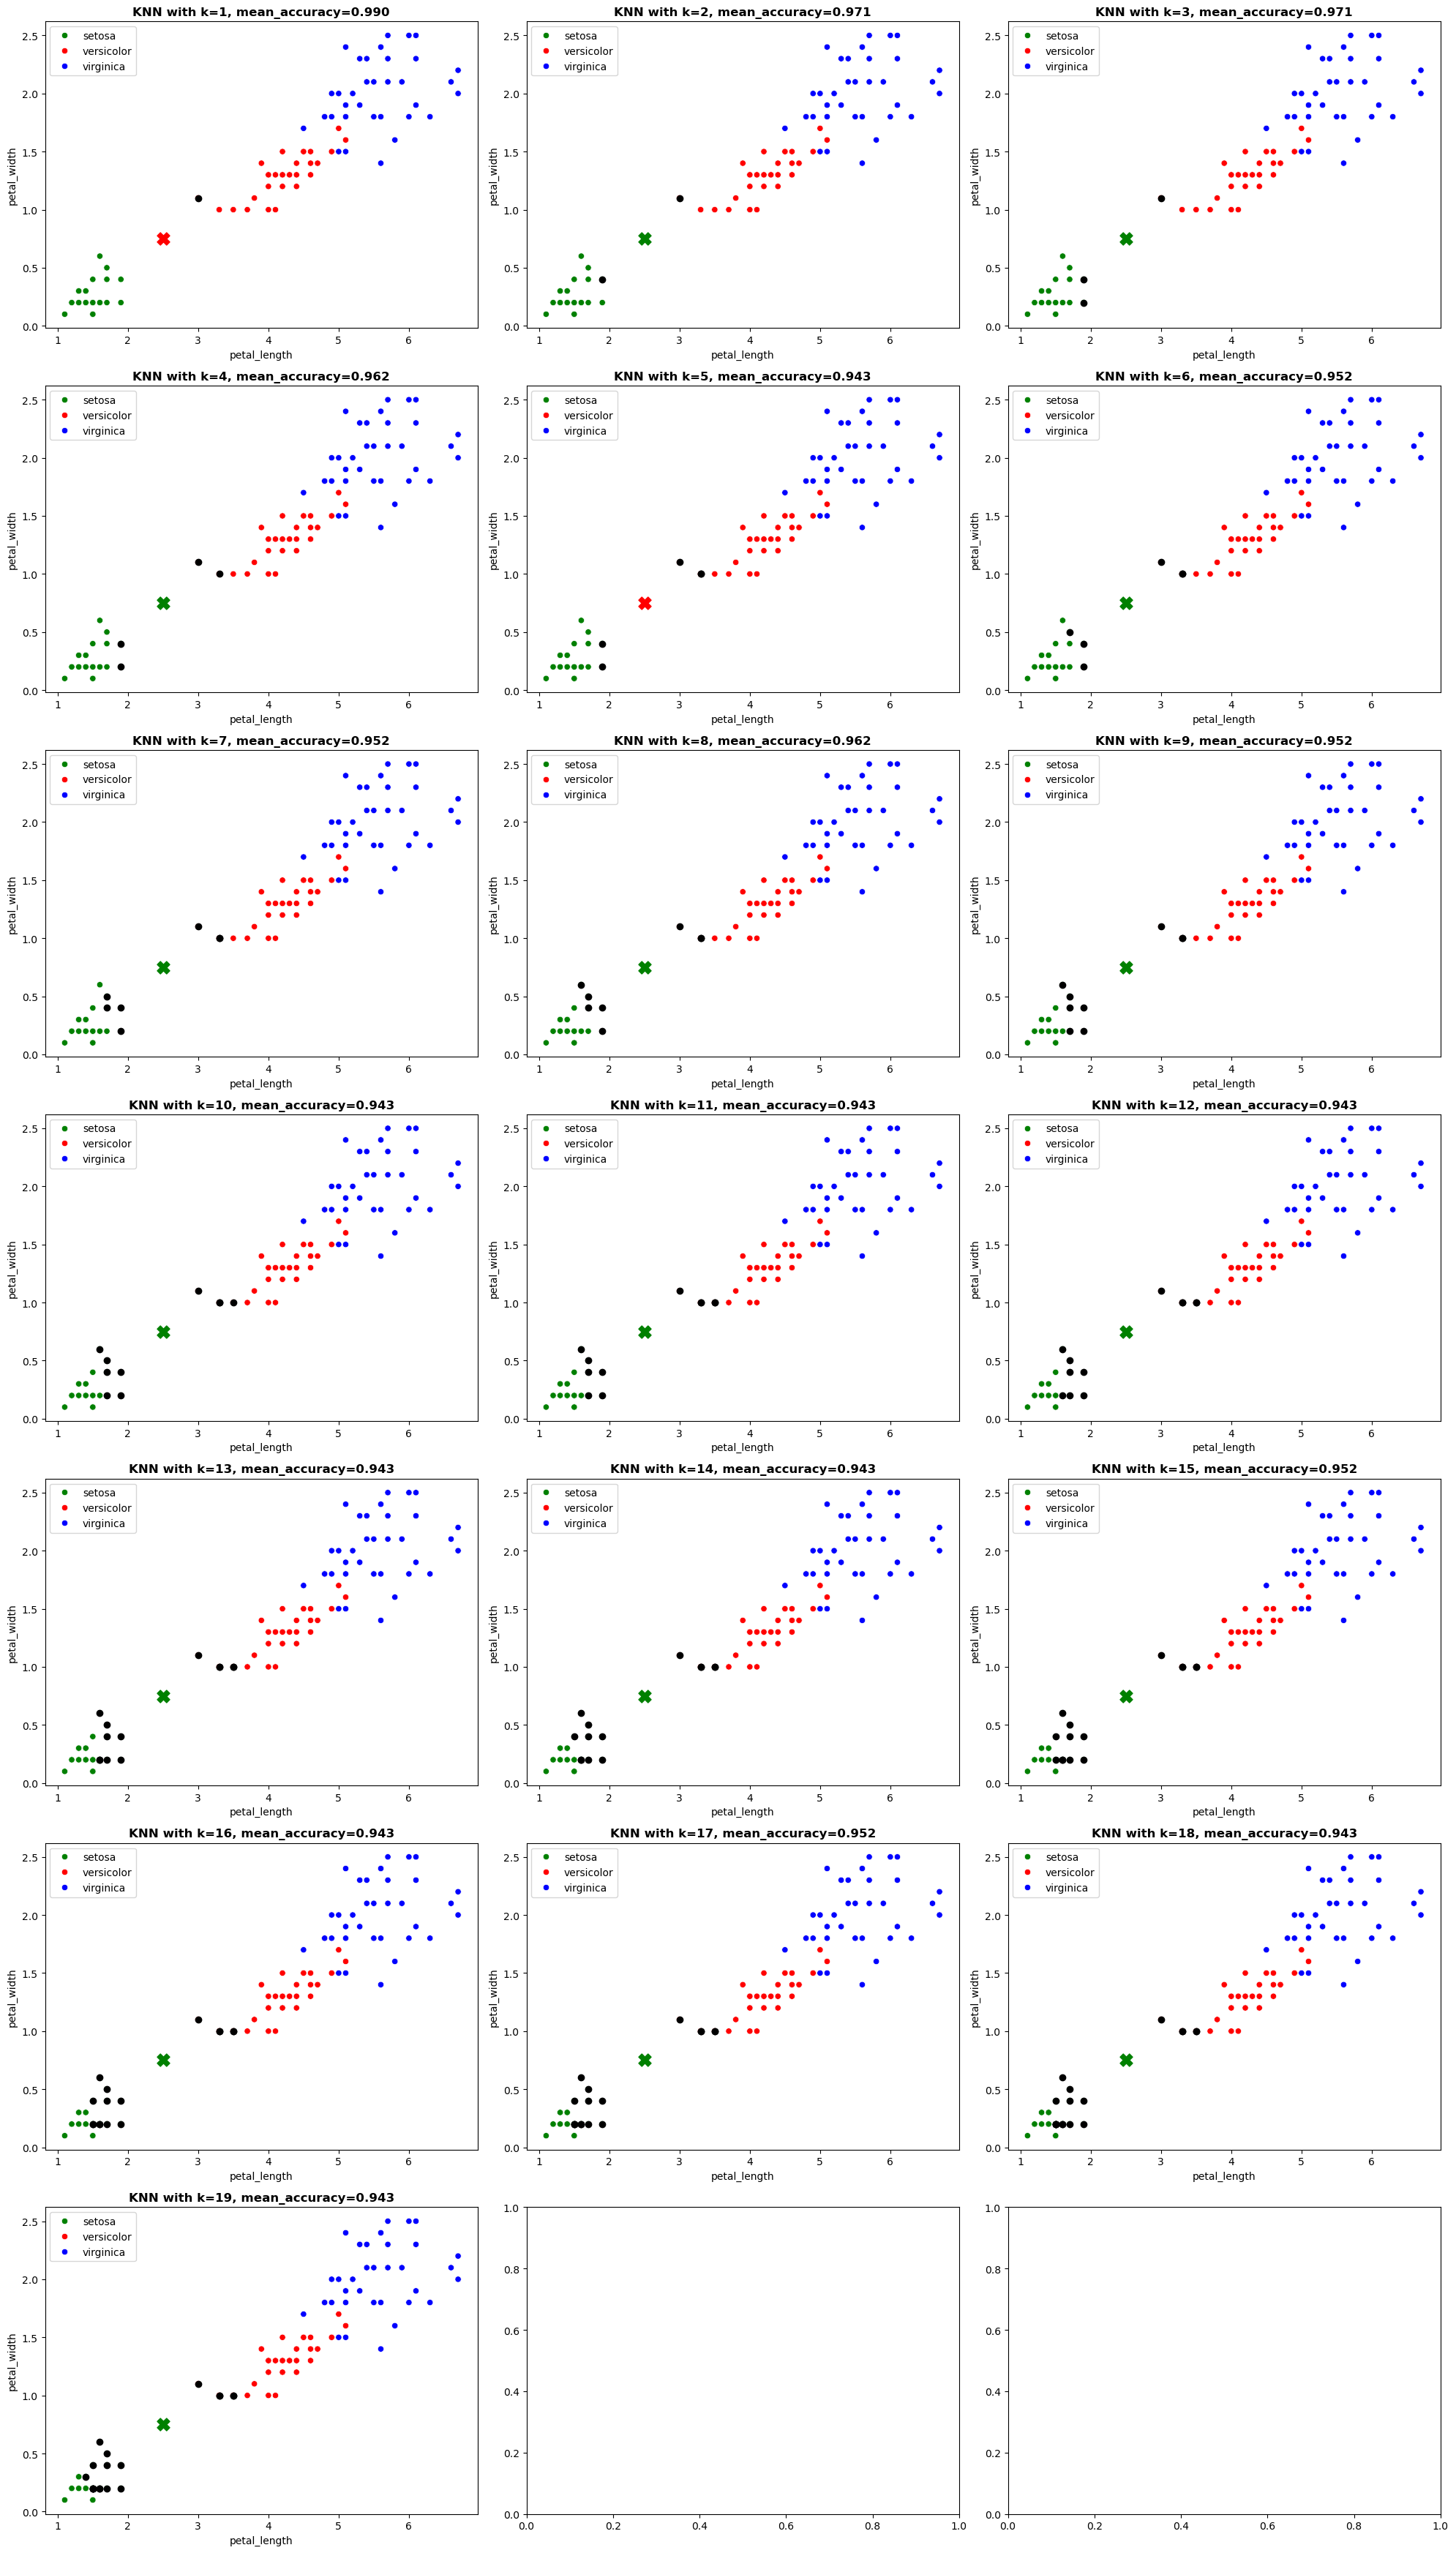

In [458]:
L, l = 2.5, 0.75
n = 20
i = int(np.ceil((n-1)/3))

# Create a figure with subplots
fig, axes = plt.subplots(i, 3, figsize=(20, 5*i)) 
axes = axes.flatten() 
for k, ax in zip(range(1, n), axes):
    predict_and_plot(L, l, k=k, ax=ax, df=dfi)
print()
plt.tight_layout()  
plt.show()

For the entire dataset (k=150), the algorithm ignores the idea of a specific proximity between the point to be predicted and the others, and simply favours the most frequent class in the dataset. 

When k is equal to the total size of the dataset (150 samples), all the samples in the dataset are taken into account to predict the class of the point of interest. In this case, as the classes are balanced, no class is in the majority (they are all equal in number), so the model could choose a class arbitrarily or according to criteria such as the order of the samples or the initialisation of the model.

Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=105, Training mean_accuracy=0.352 --------->  "1" (versicolor)


'0.352'

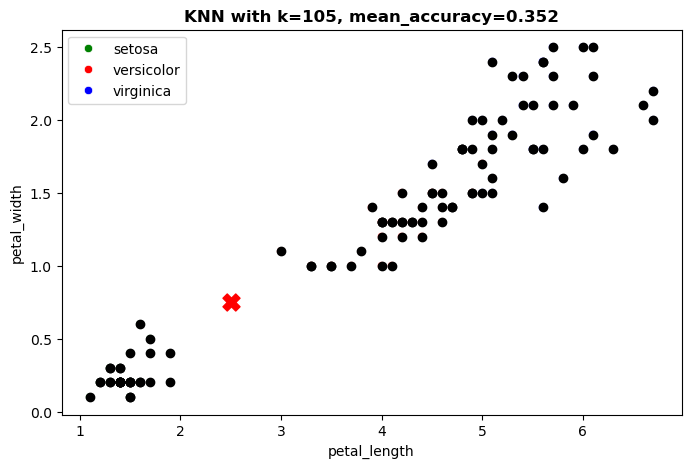

In [459]:
fig, ax = plt.subplots(figsize=(8, 5))
predict_and_plot(L, l, k=len(dfi), ax=ax, df=dfi)

Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=5, Training mean_accuracy=0.943 --------->  "1" (versicolor)


'0.943'

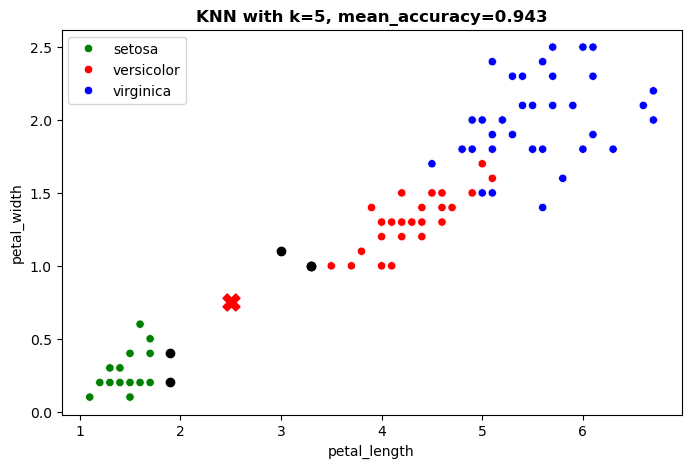

In [460]:
fig, ax = plt.subplots(figsize=(8, 5))
predict_and_plot(L, l, k=5, ax=ax, df=dfi)

# Anomaly Study for K = 5

The anomaly observed for k=5 is linked to the fact that one of the neighbours is a duplicate. The fact that there is a duplicate among the selected neighbours means that, even if k=5 is defined, the algorithm is in fact selecting 4 distinct points and one duplicate point. This prevents a correct decision being made, as the algorithm takes an extra neighbour that could influence the prediction.

In [461]:
knn, score, prediction, neighbors = predict_(L, l, k=5, df=dfi)

Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=5, Training mean_accuracy=0.943 --------->  "1" (versicolor)


In [462]:
neighbors

,petal_length,petal_width,species
98,3.0,1.1,1
44,1.9,0.4,0
24,1.9,0.2,0
93,3.3,1.0,1
57,3.3,1.0,1


# Are there any Duplicates in the data?

- df.duplicated() returns a series of Boolean values indicating whether a line is a duplicate of previous lines
  
- df[df.duplicated(keep=False)] returns all rows of the DataFrame that are duplicates, where keep=False means that all occurrences of duplicates will be kept, not just the first one.


<br>

The result of `sum(df.duplicated())` shows that there are 47 duplicates in the DataFrame. These duplicates concern rows where all the columns are identical, and they represent 71 rows in total (some rows appear several times).



<br>

Duplicate neighbours distort predictions because the algorithm considers a duplicate point to have a disproportionate influence on the predicted class, particularly in a context of balanced classes where each neighbour counts. 

To solve this problem, we can eliminate duplicates from the dataset before applying KNN, to avoid identical points being taken into account as neighbours. Another method would be to adjust the value of k to better manage the situation.


In [463]:
sum(df.duplicated())

47

In [464]:
df[df.duplicated(keep=False)].sort_values(by=list(df.columns[:-1]))

,petal_length,petal_width,species
14,1.2,0.2,0
35,1.2,0.2,0
2,1.3,0.2,0
36,1.3,0.2,0
38,1.3,0.2,0
...,...,...,...
142,5.1,1.9,2
116,5.5,1.8,2
137,5.5,1.8,2
136,5.6,2.4,2


# Are there pairs `(petal_length, petal_width)` of different `species`?


There are pairs (petal_length, petal_width) associated with several species in our dataset. This shows that there are situations where identical petal_length and petal_width values can be associated with several different species, which can make the classification task more complex for a KNN model.

For example, (4.8, 1.8) appears for species 1 (versicolor) and 2 (virginica) in lines 70, 126, and 138.

<br>

This can influence the classification model in several ways:

- Classification ambiguity: When a particular combination of petal_length and petal_width is shared between several species, the model may encounter difficulties in assigning a precise class to new data with the same characteristics. This leads to ambiguity in the prediction and can affect the accuracy of the model.

- Reducing Model Accuracy: **KNN works by finding the nearest data points (neighbours) and assigning the majority class**. If the nearest neighbours belong to different species despite having identical values for certain characteristics, this can reduce the accuracy of the predictions.


- Sensitivity to k values: As observed previously, the choice of k can change the classification results when the nearest neighbours are made up of several classes. The model may predict different classes depending on the value chosen for k, which can complicate the interpretation of the results and make the model sensitive to this parameter.

- Generalisability problems: If such ambiguous combinations are frequent in the training data, the model may have difficulty generalising correctly to new data. It could place too much weight on these ambiguous examples, leading to less reliable predictions on real data.

<br>

If values of (petal_length, petal_width) lead to several classes, we may consider removing some of these points, particularly if they introduce uncertainty into the classification.

In [465]:
# Trouver les combinaisons de (petal_length, petal_width) associées à plusieurs espèces
duplicates = df.groupby(['petal_length', 'petal_width'])['species'].nunique()
duplicates = duplicates[duplicates > 1].index

# Filtrer le DataFrame pour obtenir ces lignes spécifiques
duplicate_rows = df[df.set_index(['petal_length', 'petal_width']).index.isin(duplicates)]
duplicate_rows

,petal_length,petal_width,species
70,4.8,1.8,1
126,4.8,1.8,2
138,4.8,1.8,2


# Test with Prepared Data

Data cleansing ensures that machine learning models run on quality data, facilitating better identification of relationships, increased robustness and improved accuracy of predictions. Without good cleansing, even the best algorithms risk producing biased or unreliable results. 

Therefore, cleansing is one of the essential foundations of a successful data analysis or modelling project.

## Drop Duplicated lines

In [466]:
cleaned_df = df.drop_duplicates(keep='first')
print(cleaned_df.shape)
cleaned_df

(103, 3)


,petal_length,petal_width,species
0,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
5,1.7,0.4,0
6,1.4,0.3,0
...,...,...,...
145,5.2,2.3,2
146,5.0,1.9,2
147,5.2,2.0,2
148,5.4,2.3,2


## Drop features with different species

In [467]:
# Find combinations of (petal_length, petal_width) associated with several species
duplicates_ = cleaned_df.groupby(['petal_length', 'petal_width'])['species'].nunique()
duplicates_ = duplicates_[duplicates_ > 1].index

In [468]:
index_ = cleaned_df.set_index(['petal_length', 'petal_width']).index.isin(duplicates_)
cleaned_df = cleaned_df[~index_]

print(cleaned_df.shape)
cleaned_df

(101, 3)


,petal_length,petal_width,species
0,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
5,1.7,0.4,0
6,1.4,0.3,0
...,...,...,...
145,5.2,2.3,2
146,5.0,1.9,2
147,5.2,2.0,2
148,5.4,2.3,2


## Modeling

In the `train_test_split` function, we add the parameter `stratify=y` to ensure that the proportion of classes in the training and testing datasets is preserved.
- Stratification ensures that the class distribution in the training and test sets matches the original distribution
- Avoiding underrepresentation of certain classes in the test set
- Helps the model generalize better, especially when dealing with imbalanced data
- After training with this parameter, we can then plot the ROC curve for each class to assess how well the model is distinguishing between the different classes

In [470]:
# Splitting data into features and target
X = cleaned_df.drop(columns=['species'])
y = cleaned_df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

dfi = pd.concat([X_train, y_train], axis=1)

Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=1, Training mean_accuracy=1.000 --------->  "1" (versicolor)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=2, Training mean_accuracy=1.000 --------->  "0" (setosa)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=3, Training mean_accuracy=1.000 --------->  "1" (versicolor)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=4, Training mean_accuracy=0.986 --------->  "0" (setosa)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=5, Training mean_accuracy=0.986 --------->  "0" (setosa)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=6, Training mean_accuracy=0.986 --------->  "0" (setosa)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=7, Training mean_accuracy=0.986 --------->  "0" (setosa)
Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=8, Training mean_accuracy=0.971 --------->  "0" (setosa)
Prediction for Longueur (2.5 cm) and Largeur (0.

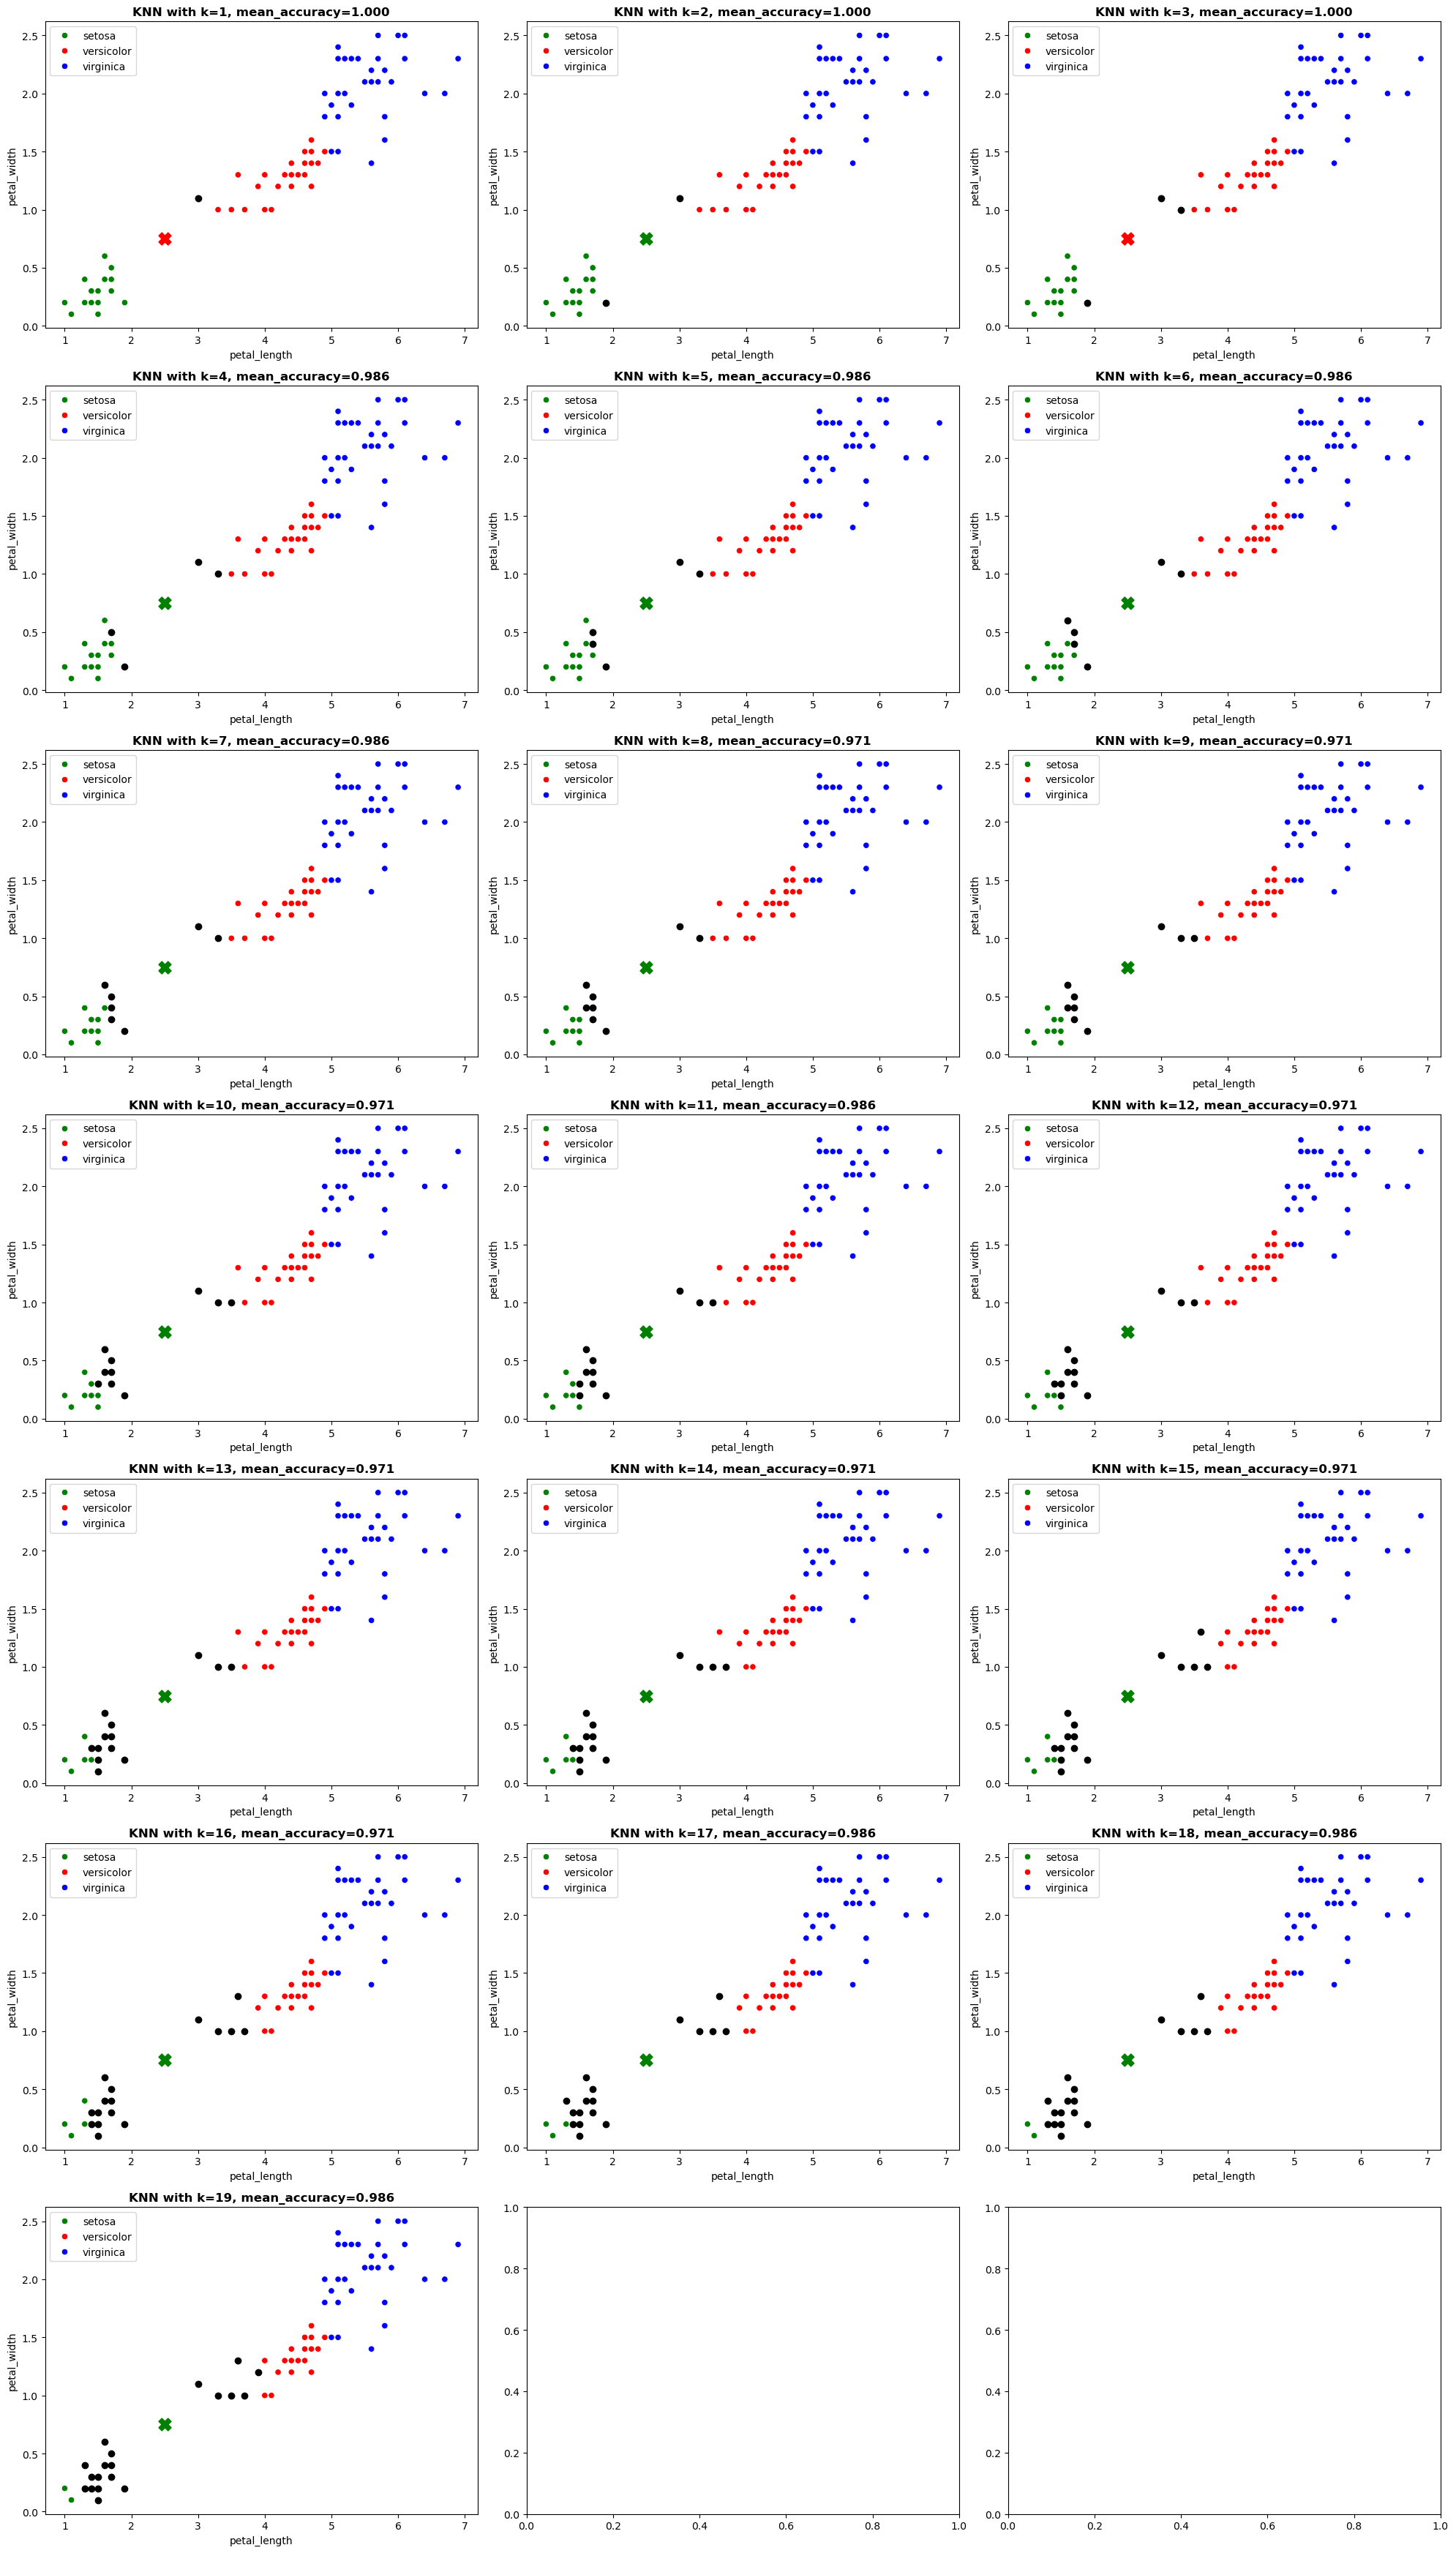

In [471]:
L, l = 2.5, 0.75
n = 20
i = int(np.ceil((n-1)/3))
scores = []
ks = []

# Create a figure with subplots
fig, axes = plt.subplots(i, 3, figsize=(20, 5*i)) 
axes = axes.flatten() 
for k, ax in zip(range(1, n), axes):
    sc = predict_and_plot(L, l, k=k, ax=ax, df=dfi)
    scores.append(float(sc))
    ks.append(k)
print()
plt.tight_layout()  
plt.show()

Duplicate data and conflicting values (such as identical combinations of petal_length and petal_width belonging to different species) were eliminated.

We can see that after cleaning the data, we observe the correct number of neighbours for k=5 and for all k>5. Also, the predicted class for k=5 is ‘setosa’ whereas the results with the unprepared data led to the prediction of the class ‘versicolor’. In addition, we observe on the graphs that the number of neighbours selected now corresponds to the value of k, which was not the case when we observed the results of the model with unprepared data.


These results highlight the importance of data preparation in improving the performance and reliability of classification models such as KNN. This ensures better model behaviour and improves the accuracy of predictions by removing ambiguities and ensuring consistency in neighbour selections.

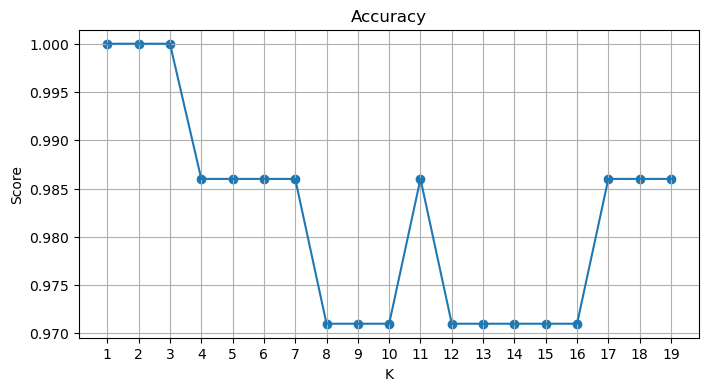

In [472]:
plt.figure(figsize=(8, 4))
plt.plot(ks, scores, label='Accuracy')
plt.scatter(ks, scores)
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Accuracy')
plt.grid(True)
plt.xticks(ticks=ks, labels=[f'{k}' for k in ks])

plt.show()

# Evaluation

Choosing an odd value for K is beneficial because it:
- helps avoid ties (equal number of neighbors from different classes) when classifying a data point
- ensures that one class will have a majority, leading to more consistent and clear-cut predictions

Choosing  K=3  is a reasonable decision because:
- it achieves perfect classification accuracy (1.0) while maintaining a balance between overfitting and underfitting
- It avoids averaging over too many neighbors, which could dilute class boundaries

In [473]:
knn, score, prediction, neighbors = predict_(L, l, k=3, df=dfi)

Prediction for Longueur (2.5 cm) and Largeur (0.75 cm) and K=3, Training mean_accuracy=1.000 --------->  "1" (versicolor)


In [474]:
# Predictions
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

Accuracy: 0.9032258064516129
F1 Score: 0.9027137736815157


___

### Classification Report

This report summarizes the performance for each class using precision, recall, and F1-score


### Interpretation

For Class 0 (Setosa):
- Precision: 1.00 (all predicted as class 0 are actually class 0)
- Recall: 1.00 (all class 0 instances are correctly identified)
- F1-Score: 1.00 (perfect harmonic mean of precision and recall)
- Support: 7 (total instances of class 0)
- Interpretation: Perfect classification for class 0

 
For Class 1 (Versicolor):
- Precision: 0.90 (90% of instances predicted as class 1 are correct)
- Recall: 0.82 (82% of class 1 instances are correctly identified)
- F1-Score: 0.86 (average performance for class 1)
- Support: 11 (total instances of class 1)
- Interpretation: The model has moderate difficulty distinguishing class 1, leading to both false positives and false negatives


ForClass 2 (Virginica):
- Precision: 0.86 (86% of instances predicted as class 2 are correct).
- Recall: 0.92 (92% of class 2 instances are correctly identified).
- F1-Score: 0.89 (good performance for class 2).
- Support: 13 (total instances of class 2).
- Interpretation: The model performs well for class 2 but with slight confusion.


For Overall Accuracy:
- Accuracy: 0.90 (90% of predictions are correct across all classes)
- Macro Average: Precision, recall, and F1-score are all 0.92, reflecting balanced performance across classes
- Weighted Average: Accounts for class imbalance, with all metrics at 0.90
 

In [475]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.90      0.82      0.86        11
           2       0.86      0.92      0.89        13

    accuracy                           0.90        31
   macro avg       0.92      0.91      0.92        31
weighted avg       0.90      0.90      0.90        31



___

### Confusion Matrix

The confusion matrix provides details about the model’s predictions for each class


### Interpretation
 

For Class 0 (Setosa):
- True Positives (TP): 7 (correctly predicted as class 0)
- False Positives (FP): 0 (no incorrect predictions as class 0)
- False Negatives (FN): 0 (no missed predictions for class 0)
- Interpretation: The model perfectly predicts all instances of class 0


For Class 1 (Versicolor):
- TP: 9 (correctly predicted as class 1)
- FP: 2 (incorrectly predicted as class 1 but belong to other classes)
- FN: 2 (class 1 instances incorrectly predicted as another class)
- Interpretation: The model does well but confuses class 1 with other classes, especially class 2


For Class 2 (Virginica):
- TP: 12 (correctly predicted as class 2)
- FP: 1 (incorrectly predicted as class 2 but belong to another class)
- FN: 1 (class 2 instances incorrectly predicted as another class)
- Interpretation: The model performs well but has slight confusion between class 2 and other classes


In [476]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 7,  0,  0],
       [ 0,  9,  2],
       [ 0,  1, 12]])

(31,)
species
2    13
1    11
0     7
Name: count, dtype: int64


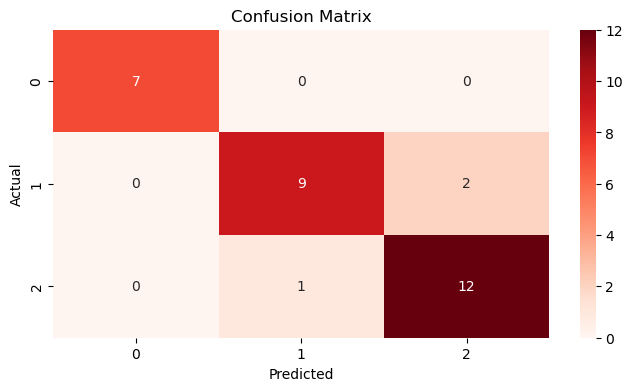

In [477]:
print(y_test.shape)
print(y_test.value_counts())

plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['0', '1', '2'],  yticklabels=['0', '1', '2'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

___

### ROC Curve (Receiver Operating Characteristic)


### Interpretation

- The diagonal line represents the performance of a random classifier. Any curve above this line indicates better-than-random performance
- The AUC (Area Under the Curve) quantifies the model’s ability to distinguish between classes

For Class 0 (Setosa):
- AUC (Area Under the Curve) = 1.00: This indicates perfect classification for this class
- The model achieves 100% true positive rate without any false positives for class 0
- The green curve reaches the top-left corner, showing the model performs perfectly for this class


For Class 1 (Versicolor):
- AUC = 0.88: This reflects good performance but not perfect
- The model has some difficulty distinguishing class 1 from the others, leading to some false positives and false negatives
- The red curve is closer to the top-left corner but not as tight as for class 0


For Class 2 (Virginica):
- AUC = 0.91: The model performs well for class 2 but not perfectly
- There is some overlap with other classes.
- The blue curve shows strong performance, although slightly below class 0

Overall, the ROC curve suggests excellent classification performance for class 0 and strong but not perfect performance for classes 1 and 2

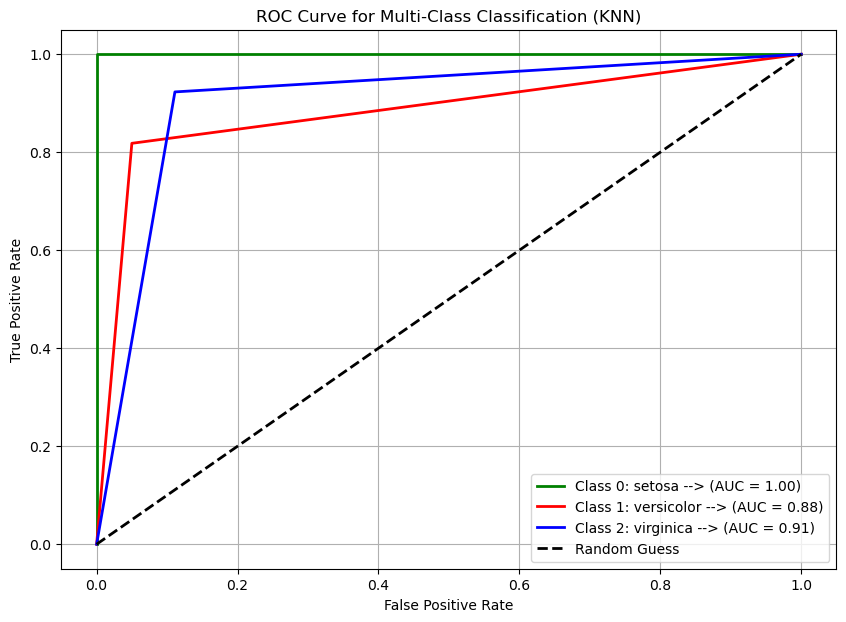

In [497]:
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(y))
y_score = knn.predict_proba(X_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f"Class {i}: {label[i]} --> (AUC = {roc_auc[i]:.2f})")

# Plot the diagonal line (random guess)
plt.plot([0, 1], [0, 1], color="black", linestyle="--", lw=2, label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification (KNN)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

<br>

___

- The model performs perfectly for class 0, very well for class 2, and reasonably well for class 1
- The ROC curve, confusion matrix, and classification report highlight that most errors occur when distinguishing between classes 1 and 2
- Improvements may focus on reducing confusion between classes 1 and 2 to increase overall accuracy

 